Этот проект по большей части является презентацией трейдинговой стратегии. Также он реализует скрейпинг отчетности выбранной для анализаа компании. 

Краткое описание на основе критериев:
1. Получение данных. Я использовал yfinance, BeautifulSoup, Selenium, yfinance. С помощью yfinance я скачиваю исторические данные котировок. Selenium необходим для работы BeautifulSoup, которым я извлекаю данные по отчетностям компании.
2. Обработка данных. Стратегия использует скользящие средние, то есть окна. Также были проведены различные более простые манипуляции с данными, cоздана таблица с выбранным отчетом.
3. Регулярные выражения. Я их использовал при работе со ссылками во втором разделе. Еще они иногда всплывают в подписях к графикам.
4. Numpy был использован при обработке данных внутри трейдинговой стратегии. 
5. Визуализация данных. Я использовал matplotlib, mplfiance, plotly. В зависимости от задачи было удобнее использовать различные библиотеки.
6. Дополнительные технологии. Ipywidgets просто делают жизнь сильно лучше, помогают настроить параметры стратегии и много всего еще. Yfinance использовался мной для удобного скачивания таблицы с историческими котировками. Plotly и mplfinace были нужны для более красивой визуализации. Datetime позволил применить виджеты для выбора диапазона времени, за который далее скачивались данные. IPython.display просто, чтобы показать виджеты.
7. Общее. Строчек тут 150. Надеюсь, проект вам понравится.
Что тут точно можно не искать:
Работу с геоданными
Работу с графами
SQL
Streamlit
Машинное обучение

Импортируем всякое. Вероятно, понадобится скачать определенные библиотеки. Также стоит отметить, что selenium использует браузер Chrome.

In [4]:
import math
import time
import re
import requests
import pandas as pd
import numpy as np
import bs4
from bs4 import BeautifulSoup
import scipy #без него не работает plotly по неизвестной причине
from selenium import webdriver
import yfinance as yf
from datetime import timedelta, datetime
import mplfinance as mpf
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px 
from plotly.subplots import make_subplots
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

Раздел первый: трейдинговая стратегия.
Гайд: запускаете ячейку ниже, далее вводите параметры, запускаете следующую ячейку.

Тут я обозначаю виджеты. Чтобы не искать тикеры, вот небольшой список для тестирования (но вообще можно любой тикер вписать)
Apple тикер: AAPL
Meta тикер: META
Alibaba тикер: BABA
Nvidia тикер: NVDA
Период лучше выбирать не длиннее полутора лет, чтобы понятнее были графики.

In [5]:
company_input = widgets.Text(
    value = '',
    placeholder = 'Type something',
    description = 'Введите тикер:',
    disabled = False,
    style = {'description_width': 'initial'}  
    )
first_day_input = widgets.DatePicker(
    description = 'Начало периода: ',
    disabled = False,
    style = {'description_width': 'initial'}
    )
last_day_input = widgets.DatePicker(
    description = 'Конец периода: ',
    disabled = False,
    style = {'description_width': 'initial'}
    )
display(company_input)
display(first_day_input)
display(last_day_input)

Text(value='', description='Введите тикер:', placeholder='Type something', style=TextStyle(description_width='…

DatePicker(value=None, description='Начало периода: ', step=1, style=DescriptionStyle(description_width='initi…

DatePicker(value=None, description='Конец периода: ', step=1, style=DescriptionStyle(description_width='initia…

Здесь скачиваются данные по введенным параметрам, а также строится график по ним, чтобы примерно представлять, с чем мы имеем дело.

[*********************100%***********************]  1 of 1 completed


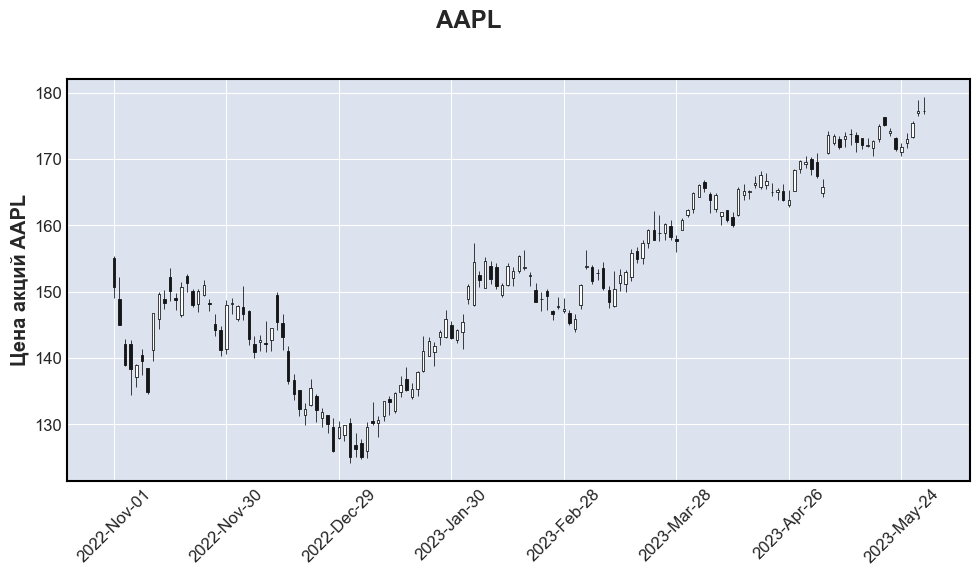

In [6]:
company = company_input.value
first_day = first_day_input.value
first_day.strftime("%Y-%m-%d")
last_day = last_day_input.value
last_day.strftime("%Y-%m-%d")
dataf = yf.download(
    tickers = company, 
    start = first_day, 
    end = last_day, 
    repair = True
    )   
dataf = pd.DataFrame(dataf)
mpf.plot(
    dataf, 
    type = 'candle', 
    figratio = (12, 5.5), 
    title = company, 
    ylabel = 'Цена акций {}'.format(company)
    )

Смотрим статистику. Стоит отметить, что стратегия, которая будет ниже, работает лучше для более волатильных акций.

In [7]:
dataf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,145.000000,145.000000,145.000000,145.000000,145.000000,1.450000e+02
mean,151.789518,153.536276,150.243311,151.999034,151.703467,6.839008e+07
std,13.337091,13.161939,13.755607,13.540308,13.639223,2.099078e+07
min,126.010002,127.769997,124.169998,125.019997,124.656982,3.519590e+07
25%,142.360001,144.500000,140.899994,142.910004,142.495041,5.372450e+07
50%,150.199997,152.699997,148.559998,150.820007,150.382065,6.544740e+07
75%,162.440002,165.050003,161.910004,163.770004,163.543793,7.743280e+07
max,177.330002,179.350006,176.759995,177.300003,177.300003,1.601569e+08


Описание стратегии:
За основу взята типичная стратегия со скользящими средними по цене закрытия, где один показатель отражает разницу между длинной и короткой скользящей, другой показатель - скользящая средняя по предыдущему. Пересечение графиков этих показателей - сигнал к продаже или покупке, в зависимости от того, как происходит пересечение. Я заменил обычную скользящую среднюю экспоненциально сглаженной, чтобы отразить, что данные, которые ближе к сегодняшнему дню важнее. Вместо обычных средних я использовал взвешенные по объему.
В общем, индикатор vwap был засунут внутрь стратегии по macd.

In [33]:
def strategy_calc(
  dataf, money, l_ema_length, s_ema_length, signal_length, leverage
  ):
  #создаем длинную скользящую, взвешенную по объему
  typical_price = (dataf['Close'] + dataf['High'] + dataf['Low']) / 3
  volume_ema_long  = dataf['Volume'].ewm(span = l_ema_length).mean()
  cummulative_price_ema_long = (typical_price*dataf['Volume']).ewm(
  span = l_ema_length).mean()
  ema_long = cummulative_price_ema_long/volume_ema_long
  #создаем короткую скользящую, взвешенную по объему
  volume_ema_short  = dataf['Volume'].ewm(span = s_ema_length).mean()
  cummulative_price_ema_short = (typical_price*dataf['Volume']).ewm(
  span = s_ema_length).mean()
  ema_short = cummulative_price_ema_short / volume_ema_short
  #создаем искомые скользящие
  vwap_macd = ema_short - ema_long
  signal = vwap_macd.ewm(span = signal_length).mean()

  buy = list()
  sell = list()
  cashflow  = list()
  ind_list = list()
  performance = list()
  ind = 0
  #сама стратегия, параллельно еще считаем необходимые показатели
  for i in range(1, len(signal)):
    if signal[i-1] > vwap_macd[i-1] and signal[i]<vwap_macd[i]:
      buy.append(dataf['Close'][i-1])
      sell.append(np.nan)
      if ind == 0:
        cashflow.append(-1*dataf['Close'][i-1])
        ind = 1
        ind_list.append(ind)
      else:
        cashflow.append(-2*dataf['Close'][i-1])
        ind = 1
        ind_list.append(ind)
    elif signal[i-1] < vwap_macd[i-1] and signal[i]>vwap_macd[i]:
      sell.append(dataf['Close'][i-1])
      buy.append(np.nan)
      if ind == 0:
        cashflow.append(1*dataf['Close'][i-1])
        ind = -1
        ind_list.append(ind)
      else:
        cashflow.append(2*dataf['Close'][i-1])
        ind = -1
        ind_list.append(ind)
    else: 
      buy.append(np.nan)
      sell.append(np.nan)
      ind_list.append(ind)
      cashflow.append(0)
  ind_list.append(ind)
  buy.append(np.nan)
  sell.append(np.nan)
  #в portfolio будем хранить иформацию о нашей текущей позиции
  portfolio = (dataf['Close']) * ind_list
  portfolio[-1] = 0
  #в cashflow будем записывать сколько приходит и уходит кэша на счете
  cashflow.append(ind_list[-1]*dataf['Close'][-1])
  cashflow = np.array(cashflow)
  #считаем как меняется наш депозит и учитываем плечо
  for i in range(len(signal)):
    performance.append(leverage*(cashflow[:i+1].sum()+portfolio[i]))
    portfolio[i] = leverage * portfolio[i] * math.floor(money / max(dataf['Close']))
  for i in range(len(performance)):
    performance[i] = money + (math.floor(money / max(dataf['Close']))) * performance[i]
    cashflow[i] = cashflow[i] * leverage * math.floor(money / max(dataf['Close']))
  #создаем дополнительные колонки для построения графиков далее
  dataf['Buy'] = buy
  dataf['Sell'] = sell
  dataf['Performance'] = performance
  dataf['Portfolio'] = portfolio
  dataf['Cashflow'] = cashflow
  #выводим итоги
  print('Чистая прибыль: ' + str(performance[-1] - money))
  print('ROI: ' + str((performance[-1] - money) / money))
  #строим график с точками входа в лонг и в шорт
  fig = plt.figure(figsize = (12.5, 4.5))
  chart = fig.add_subplot()
  chart.set_title('Стратегия  {}'.format(company))
  chart.scatter(
    dataf.index, 
    dataf['Buy'], 
    color = 'green', 
    alpha = 0.65, 
    label = 'Покупаем'
    )
  chart.scatter(
    dataf.index, 
    dataf['Sell'], 
    color = 'red', 
    alpha = 0.65, 
    label = 'Шортим'
    )
  chart.plot(
    dataf['Close'], 
    alpha = 0.35, 
    color = 'blue', 
    label = '{}'.format(company)
    )
  chart.legend(loc = 'best')
  chart.set_ylabel('Цена акций {}'.format(company))
  plt.show()

Создаем виджеты для настройки стратегии и выбора кредитного плеча.
Я уже поиспытывал стратегию и настроил более менее оптимально как по умолчанию.
Выводим график с ценой акции и точками входа в лонг и в шорт.
Чистая прибыль и ROI считаются примерно исключительно для наглядности.

In [34]:
money_input = widgets.IntText(
    step = 10,
    value = 1000,
    description = 'Сумма инвестиций: ',
    continuous_update = False,
    style = {'description_width': 'initial'}
    )
l_ema_length_input = widgets.IntText(
    value = 40,
    min = 1,
    max = 70,
    step = 1,
    description = 'Длинная ema: ',
    disabled = False,
    continuous_update = False,
    style = {'description_width': 'initial'}
    )
s_ema_length_input = widgets.IntText(
    value = 1,
    min = 1,
    max = 40,
    step = 1,
    description = 'Короткая ema: ',
    disabled = False,
    continuous_update = False,
    style = {'description_width': 'initial'}
    )

signal_length_input = widgets.IntText(
    value = 2,
    min = 1,
    max = 20,
    step = 1,
    description = 'Сигнальная линия: ',
    disabled = False,
    continuous_update = False,
    style = {'description_width': 'initial'}
    )
leverage_input = widgets.IntText(
    value = 1,
    min = 1,
    max = 5,
    step = 1,
    description = 'Плечо: ',
    disabled = False,
    continuous_update = False,
    style = {'description_width': 'initial'}
    )
widgets.interact(
    strategy_calc,
    dataf = widgets.fixed(dataf),
    money = money_input,
    l_ema_length = l_ema_length_input,
    s_ema_length = s_ema_length_input,
    signal_length = signal_length_input,
    leverage = leverage_input
    )

interactive(children=(IntText(value=1000, description='Сумма инвестиций: ', step=10, style=DescriptionStyle(de…

<function __main__.strategy_calc(dataf, money, l_ema_length, s_ema_length, signal_length, leverage)>

Посмотрим как именяется наш депозит по ходу работы стратегии.

In [35]:
plt.figure(figsize = (12.5, 4.5))
fig0 = px.bar(
    dataf['Performance'], 
    color = dataf['Performance']
    )
fig0.update_layout(
    title_text = 'Рост депозита',
    title_x = 0.5,
    xaxis_title = 'Момент времени',
    yaxis_title = "Депозит"
    )
fig0.show()

<Figure size 1250x450 with 0 Axes>

Тут можно посмотреть на какую сумму мы в лонге или в шорте в каждый момент времени.

In [36]:
plt.figure(figsize = (12.5, 4.5))
fig1 = px.bar(
    dataf['Portfolio'], 
    color = dataf['Portfolio']
    )
fig1.update_layout(
    title_text = 'Текущая позиция',
    title_x = 0.5,
    xaxis_title = "Момент времени",
    yaxis_title = "Позиция"
    )
fig1.show()

<Figure size 1250x450 with 0 Axes>

Визуализируем денежный поток. Если положительный, значит столько денег к нашему текущему балансу счета прибавилось от входа в шорт. Если отризательный, значит столько денег убыло с текущего счета, поскольку пришлось потратиться на покупку акций. 

In [37]:
plt.figure(figsize = (12.5, 4))
fig2 = px.scatter(
    x = dataf.index, 
    y = dataf['Cashflow'], 
    color = dataf['Cashflow']
    )
fig2.update_layout(
    title_text = 'Денежный поток',
    title_x = 0.5,
    xaxis_title = "Момент времени",
    yaxis_title = "Размер денежного поток"
    )
fig2.show()

<Figure size 1250x400 with 0 Axes>

Раздел второй: скрейпинг отчетности.
Содержательно два раздела сильно отличаются друг от друга. Но дело в том, что на сайте yahoo finace нельзя просто скачать отчетность, поэтому реализация скрейпинга отчета и последующего создания таблицы с ним - практически крайне полезная и нужная задача.

Создаем функцию для скрейпинга данных. Без Selenium тут не обойтись, поскольку yahoo finance не хочет, чтобы его скрейпили. Без Selenium заскрейпить получается только 'шаблон' страницы.

In [31]:
def downloading_statement(statement_type):
    browser = webdriver.Chrome()
    #регулярное выражение
    url = 'https://finance.yahoo.com/quote/{}/{}?p={}'
    browser.get(url.format(company, statement_type, company))
    #тусуемся на странице, чтобы лучше скрейпилось
    time.sleep(1)
    browser.execute_script("window.scrollTo(0, 100)")
    #отделение зерен от плевел
    soup = BeautifulSoup(browser.page_source)
    cleaner_soup = soup.find("div", {"class": "D(tbrg)"})
    almost_clean_soup = cleaner_soup.find_all("div", {"class": "D(tbr) fi-row Bgc($hoverBgColor):h"})
    fin_data = list()

    for i in almost_clean_soup:
        clean_data = list()
        pochti_u_celi = i.find_all("div", {"class": "D(tbc)"})
        for j in pochti_u_celi:
            clean_data.append(j.text.strip())
        fin_data.append(clean_data)
    #создание pandas датафрейма и присвоение имен колонкам
    fin_data = pd.DataFrame(fin_data)
    if statement_type == "balance-sheet":
        fin_data.columns = ['Категория', '2022', '2021', '2020', '2019']
    else:
        fin_data.columns = ['Категория', '12 месяцев', '2022', '2021', '2020', '2019']
    #выводим данные для любования
    display(fin_data)




Делаем кнопочки для выбора нужного отчета.

In [32]:
statement_type_input = widgets.ToggleButtons(
    options = [
        'financials', 
        'balance-sheet', 
        'cash-flow'
        ],
    description = 'Отчетность:',
    layout = {'width': '700px'},
    value = 'cash-flow',
    button_style = 'info',
    continuous_update = False,
    tooltips = [
        'Отчет о финансовых результатах', 
        'Баланс', 
        'Отчет о движении денежных средств'
        ],
)
widgets.interact(
   downloading_statement,
   statement_type = statement_type_input 
)

interactive(children=(ToggleButtons(button_style='info', description='Отчетность:', index=2, layout=Layout(wid…

<function __main__.downloading_statement(statement_type)>

На данном этапе можно поразглядывать отчет, чтобы понять, что так, а что не так. Можно порадоваться, что проект доделан или что завершена проверка. Надеюсь, у вас осталось хорошее впечатление от проекта.